In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.n_jobs = 10
sc.set_figure_params(dpi=300, dpi_save=300, format='pdf', frameon=False)

In [2]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
# !mkdir write

In [3]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
)
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [5]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

In [6]:
adata.layers['counts'] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.layers['log1p'] = adata.X.copy() 

In [7]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.obsm['X_pca'] = sc.pp.pca(sc.pp.scale(adata[:, adata.var.highly_variable].X))

/Users/pax/miniconda3/envs/senescence/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [8]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
sc.tl.umap(adata)

# Link community detection

   Checking for loops and duplicate edges... 100.000%
   Found and removed 20990 duplicate edge(s)
   Calculating edge similarities for 20990 edges... 100.00%
   Hierarchical clustering of edges... 100.00%
   Calculating link densities... 100.00%
   Maximum partition density =  0.06411808 
   Finishing up...4/4... 100.00%                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

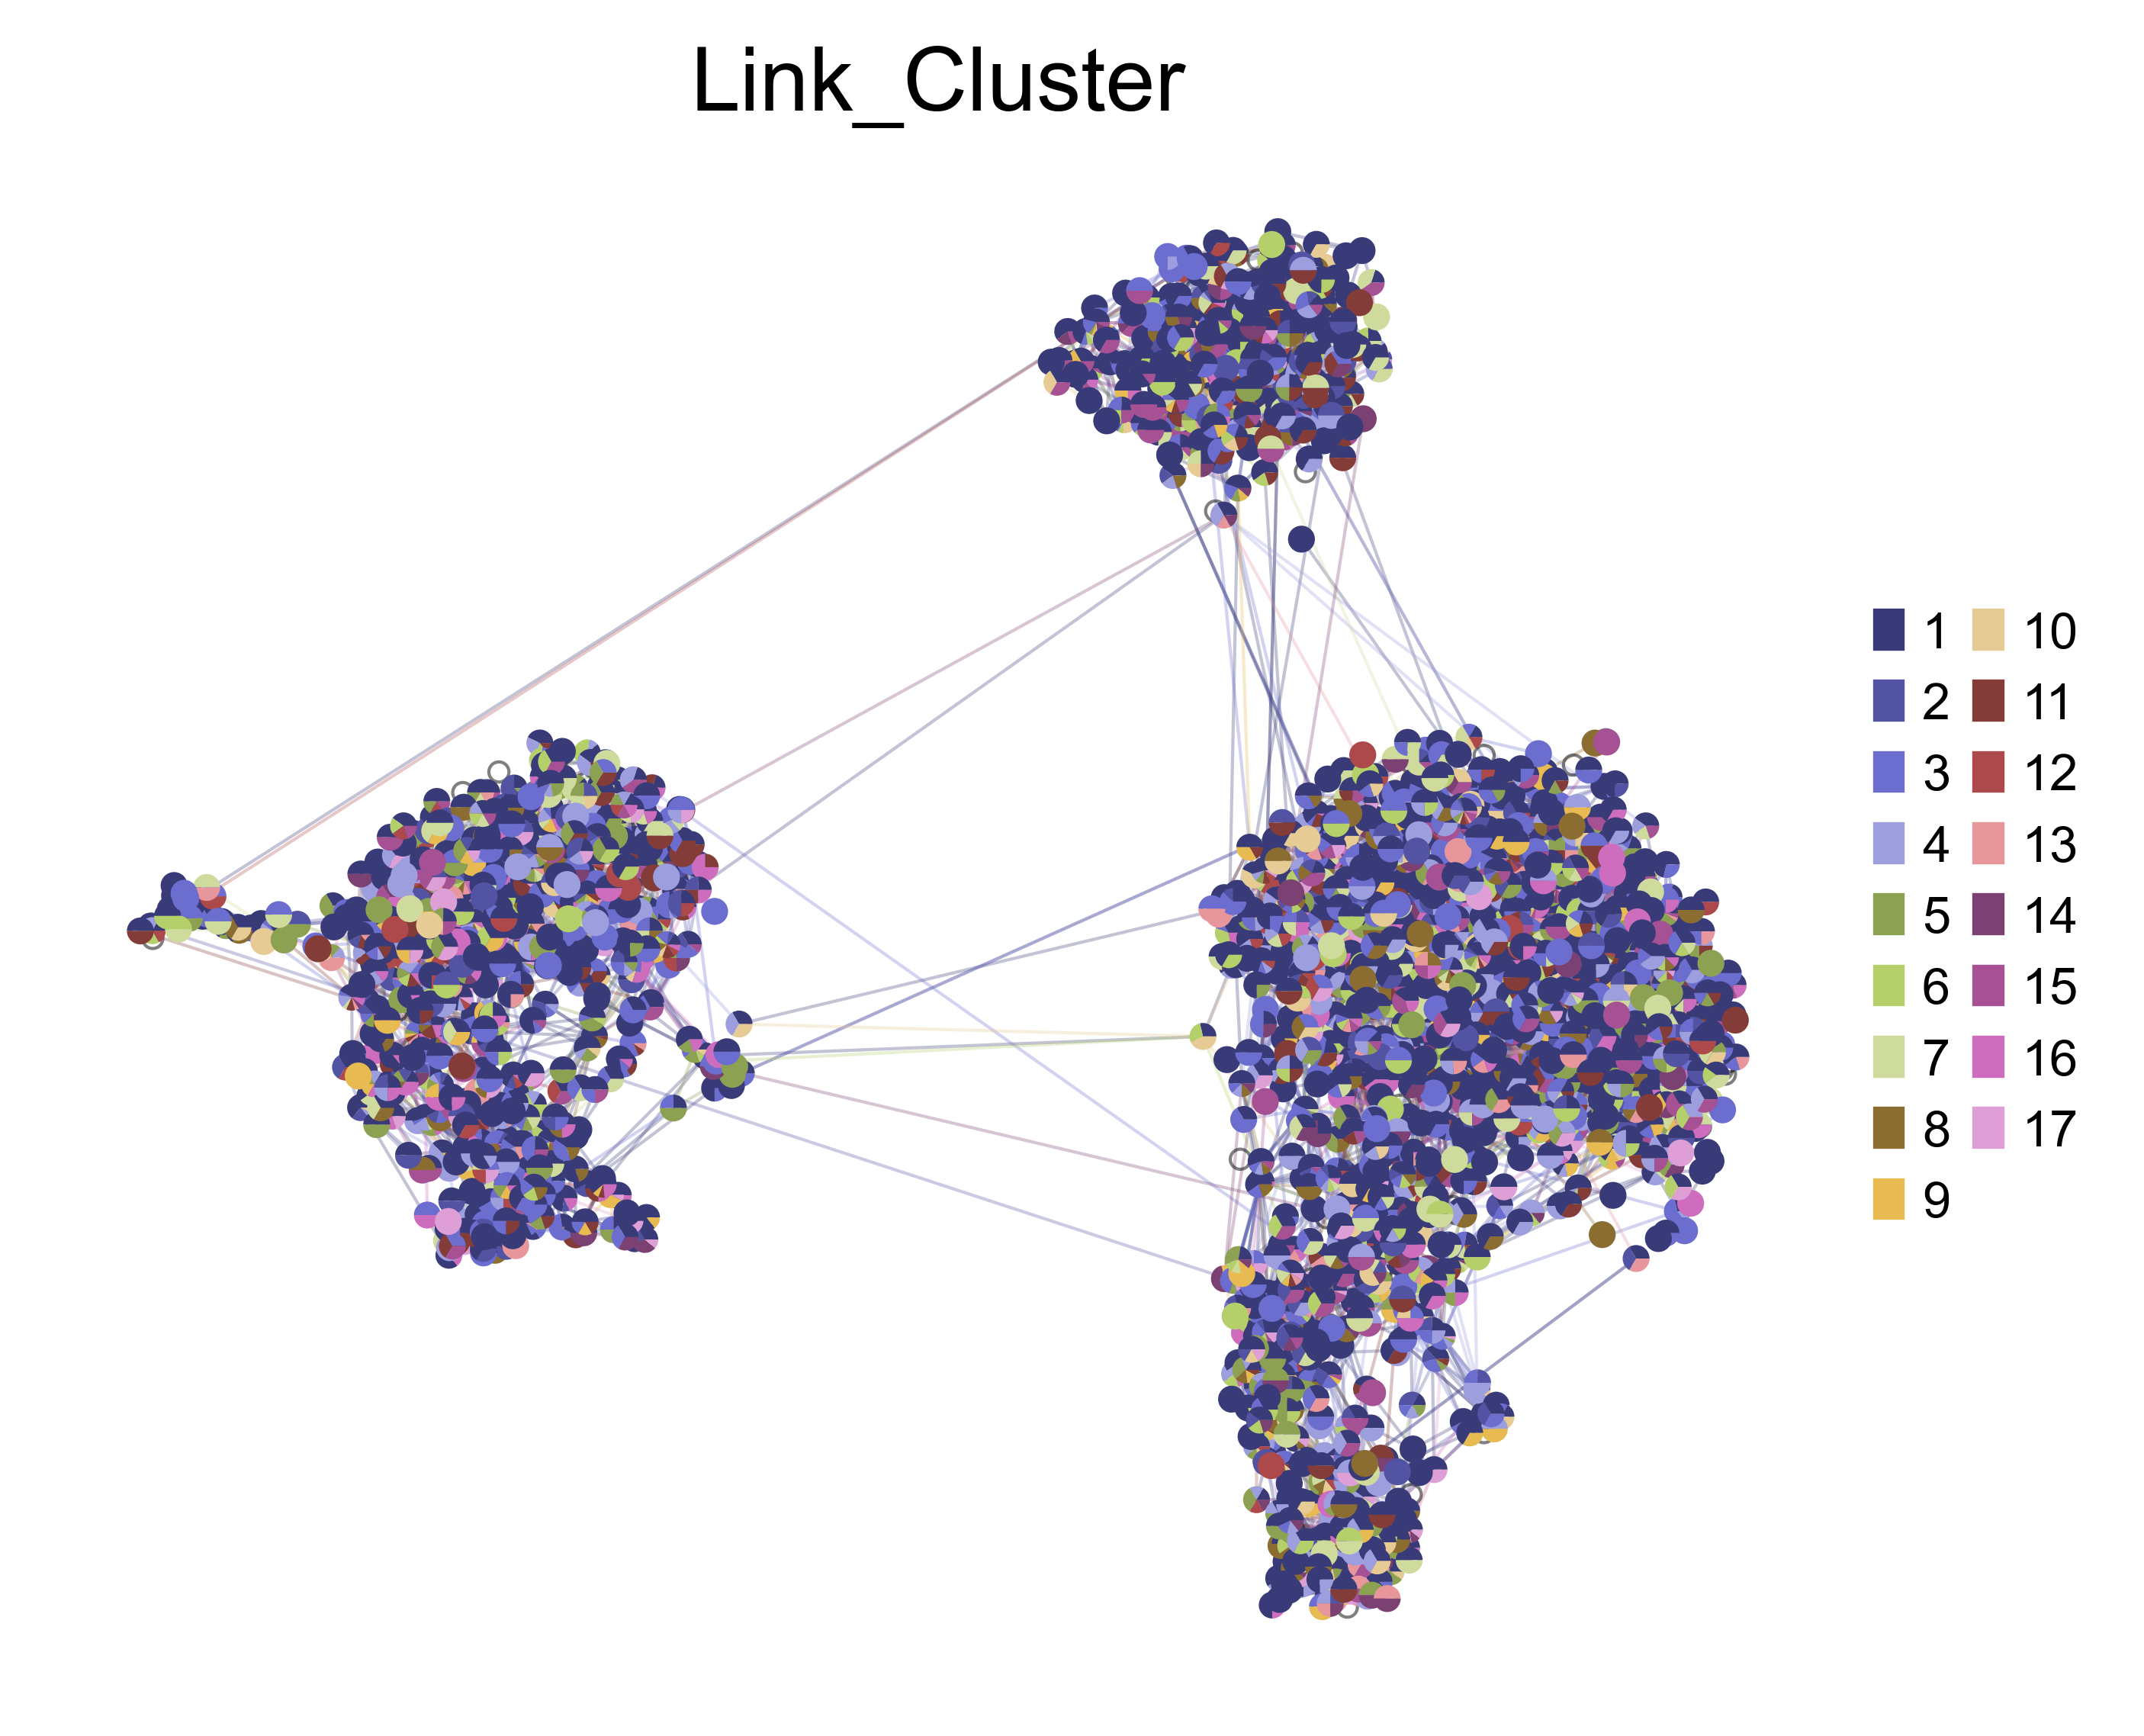

In [9]:
import scLink as scl
lc_obj = scl.tl.link_comm(adata, "connectivities")
lc_obj.run_link_comm()
fig, ax = lc_obj.plot_link_comm(adata)